In [1]:
!wget https://datasets.cellxgene.cziscience.com/4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad

--2025-12-24 06:36:28--  https://datasets.cellxgene.cziscience.com/4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 54.192.100.53, 54.192.100.121, 54.192.100.73, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|54.192.100.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12218251667 (11G) [binary/octet-stream]
Saving to: ‘4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad’

4118e166-34f5-4c1f- 100%[===================>]  11.38G  85.7MB/s    in 2m 17s  

2025-12-24 06:38:45 (85.2 MB/s) - ‘4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad’ saved [12218251667/12218251667]



In [2]:
!pip install -q scanpy[leiden] harmonypy symphonypy 2>/dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 112.5 MB/s eta 0:00:00


In [3]:
!pip install --user scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 4.7 MB/s eta 0:00:00


In [4]:
!pip install sccoda

In [5]:
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import sccoda.datasets as scd
from sccoda.util import cell_composition_data as dat
from scipy.stats import ttest_ind
from sccoda.util import comp_ana as mod
from sccoda.util import data_visualization as viz
from statsmodels.stats.multitest import multipletests
warnings.filterwarnings('ignore')

In [6]:
adata = sc.read_h5ad('4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad', backed='r')

In [7]:
adata

AnnData object with n_obs × n_vars = 1263676 × 30172 backed at '4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad'
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_uma

Делаем subsampling:

In [8]:
print(adata.obs['self_reported_ethnicity'].unique())

['Asian', 'European American', 'African American', 'Hispanic or Latin']
Categories (4, object): ['African American', 'European American', 'Hispanic or Latin', 'Asian']


In [9]:
print(adata.obs['disease'].unique())

['normal', 'systemic lupus erythematosus']
Categories (2, object): ['systemic lupus erythematosus', 'normal']


In [10]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(8)

# First, get all European American donors
european_mask = adata.obs['self_reported_ethnicity'] == 'European American'
adata_european = adata[european_mask]

print(f"Original dataset: {adata.shape[0]:,} cells")
print(f"European American donors: {adata_european.shape[0]:,} cells")

# Get unique European American donors for SLE and control
sle_donors = adata_european.obs.loc[
    adata_european.obs['disease'] == 'systemic lupus erythematosus', 'donor_id'
].unique()
control_donors = adata_european.obs.loc[
    adata_european.obs['disease'] != 'systemic lupus erythematosus', 'donor_id'
].unique()

print(f"\nAvailable SLE donors (European American): {len(sle_donors)}")
print(f"Available control donors (European American): {len(control_donors)}")

# Check disease types in control group for debugging
if len(control_donors) > 0:
    control_diseases = adata_european.obs.loc[
        adata_european.obs['donor_id'].isin(control_donors), 'disease'
    ].unique()
    print(f"Control group disease types: {control_diseases}")

# Randomly select 6 SLE donors and 6 control donors (if available)
if len(sle_donors) >= 6:
    selected_sle = np.random.choice(sle_donors, size=6, replace=False)
else:
    print(f"Warning: Only {len(sle_donors)} SLE donors (European American) available")
    selected_sle = sle_donors

if len(control_donors) >= 6:
    selected_control = np.random.choice(control_donors, size=6, replace=False)
else:
    print(f"Warning: Only {len(control_donors)} control donors (European American) available")
    selected_control = control_donors

# Combine selected donors
selected_donors = list(selected_sle) + list(selected_control)

# Create a combined mask for the original adata
# Note: We're still filtering for European American ethnicity to be safe
combined_mask = (adata.obs['self_reported_ethnicity'] == 'European American') & \
                (adata.obs['donor_id'].isin(selected_donors))

# Apply the combined mask once and convert to memory
adata_filtered = adata[combined_mask].to_memory()

print(f"\nFinal filtered dataset (European American only): {adata_filtered.shape[0]:,} cells")
print(f"Number of selected donors: {len(selected_donors)}")
print(f"  - SLE donors: {len(selected_sle)}")
print(f"  - Control donors: {len(selected_control)}")
print(f"Filtered dataset is in memory: {not adata_filtered.isbacked}")

# Optional: Show breakdown by disease status
print("\nSelected donors:")
print(f"  SLE: {selected_sle}")
print(f"  Control: {selected_control}")

# Check disease distribution in filtered data
if adata_filtered.shape[0] > 0:
    print("\nDisease distribution in filtered data:")
    disease_counts = adata_filtered.obs['disease'].value_counts()
    print(disease_counts)

    # Also check donor distribution
    print("\nDonor distribution by disease:")
    for disease in disease_counts.index:
        donors_in_disease = adata_filtered.obs.loc[
            adata_filtered.obs['disease'] == disease, 'donor_id'
        ].unique()
        print(f"  {disease}: {len(donors_in_disease)} donors")

Original dataset: 1,263,676 cells
European American donors: 738,773 cells

Available SLE donors (European American): 75
Available control donors (European American): 74
Control group disease types: ['normal']
Categories (2, object): ['systemic lupus erythematosus', 'normal']

Final filtered dataset (European American only): 59,017 cells
Number of selected donors: 12
  - SLE donors: 6
  - Control donors: 6
Filtered dataset is in memory: True

Selected donors:
  SLE: ['1203' '1726' '1947' '1368' '1225' '1815']
  Control: ['HC-006' 'IGTB826' 'ICC_control' 'IGTB1372' 'IGTB1542' 'HC-554']

Disease distribution in filtered data:
disease
normal                          33322
systemic lupus erythematosus    25695
Name: count, dtype: int64

Donor distribution by disease:
  normal: 6 donors
  systemic lupus erythematosus: 6 donors


In [11]:
adata_filtered.raw

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse

def perform_qc_on_raw(adata_filtered):


    X = adata_filtered.raw.X
    gene_names = adata_filtered.raw.var_names

    if issparse(X):
        print("Data is sparse matrix")
        n_counts = X.sum(axis=1).A1
        n_genes = (X > 0).sum(axis=1).A1
    else:
        print("Data is dense matrix")
        n_counts = X.sum(axis=1)
        n_genes = (X > 0).sum(axis=1)

    adata_filtered.obs['n_counts'] = n_counts
    adata_filtered.obs['n_genes'] = n_genes

    print(f"Total cells: {adata_filtered.n_obs:,}")
    print(f"Median counts per cell: {np.median(n_counts):.0f}")
    print(f"Median genes per cell: {np.median(n_genes):.0f}")
    return adata_filtered

adata_filtered = perform_qc_on_raw(adata_filtered)

Data is sparse matrix
Total cells: 59,017
Median counts per cell: 2030
Median genes per cell: 697


In [13]:
def get_pct_mito(adata, use_raw=True):

    if use_raw and hasattr(adata, 'raw') and adata.raw is not None:
        X = adata.raw.X
        var_names = adata.raw.var_names
    else:
        X = adata.X
        var_names = adata.var_names

    var_names_str = [str(gene) for gene in var_names]
    mito_genes = [gene for gene in var_names_str if gene.upper().startswith('ENSG000002')]

    print(f"Found {len(mito_genes)} mitochondrial genes")

    if len(mito_genes) == 0:
        print("Warning: No mitochondrial genes found with ENSG000002 pattern")
        return np.zeros(adata.n_obs), []

    mito_indices = [i for i, gene in enumerate(var_names_str) if gene in mito_genes]

    if issparse(X):
        total_counts = X.sum(axis=1).A1
        mito_counts = X[:, mito_indices].sum(axis=1).A1
    else:
        total_counts = X.sum(axis=1)
        mito_counts = X[:, mito_indices].sum(axis=1)

    pct_mito = np.zeros_like(total_counts, dtype=np.float32)
    non_zero = total_counts > 0
    pct_mito[non_zero] = (mito_counts[non_zero] / total_counts[non_zero]) * 100

    return pct_mito, mito_genes

pct_mito_values, mito_genes = get_pct_mito(adata_filtered)

# Add to adata_filtered
adata_filtered.obs['pct_mito'] = pct_mito_values

Found 12958 mitochondrial genes


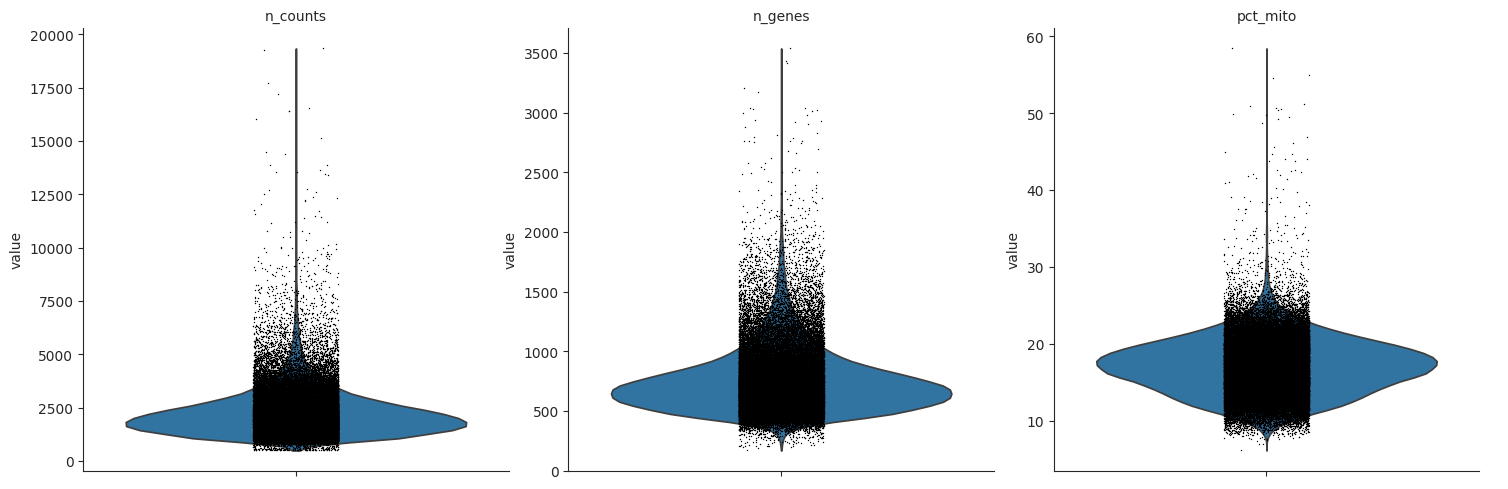

In [14]:
sc.pl.violin(adata_filtered, keys=["n_counts", "n_genes",
                          "pct_mito"], multi_panel=True)

In [15]:
print(f"Before cell filtering: {adata_filtered.shape[0]:,} cells")
sc.pp.filter_cells(adata_filtered, min_genes=100)
print(f"After cell filtering (min_genes=100): {adata_filtered.shape[0]:,} cells")

print(f"\nBefore gene filtering: {adata_filtered.shape[1]:,} genes")
sc.pp.filter_genes(adata_filtered, min_cells=10)
print(f"After gene filtering (min_cells=10): {adata_filtered.shape[1]:,} genes")

mito_col = None
for col in ['pct_counts_mt', 'pct_mito', 'pct_counts_mito']:
    if col in adata_filtered.obs.columns:
        mito_col = col
        break

print(f"Before mitochondrial filtering: {adata_filtered.shape[0]:,} cells")

low_mito_mask = adata_filtered.obs[mito_col] < 20

cells_removed = (~low_mito_mask).sum()
print(f"Cells to remove (mito >= 20%): {cells_removed:,}")

adata_filtered = adata_filtered[low_mito_mask, :]
print(f"After mitochondrial filtering: {adata_filtered.shape[0]:,} cells")


Before cell filtering: 59,017 cells
After cell filtering (min_genes=100): 25,397 cells

Before gene filtering: 30,172 genes
After gene filtering (min_cells=10): 1,888 genes
Before mitochondrial filtering: 25,397 cells
Cells to remove (mito >= 20%): 3,025
After mitochondrial filtering: 22,372 cells


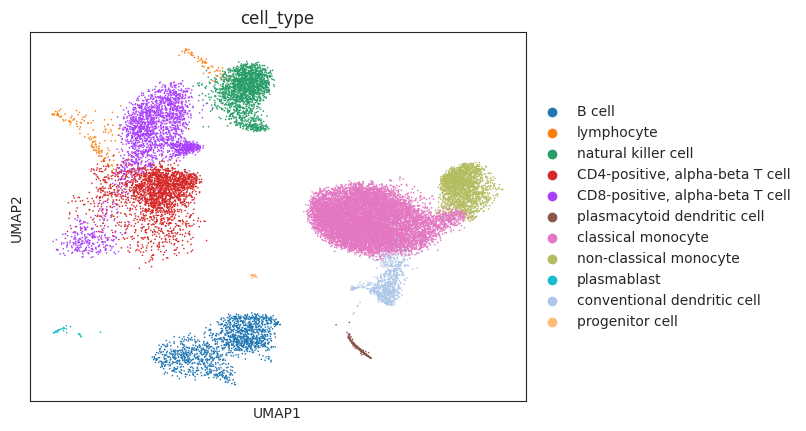

In [16]:
sc.pl.umap(adata_filtered, color='cell_type')

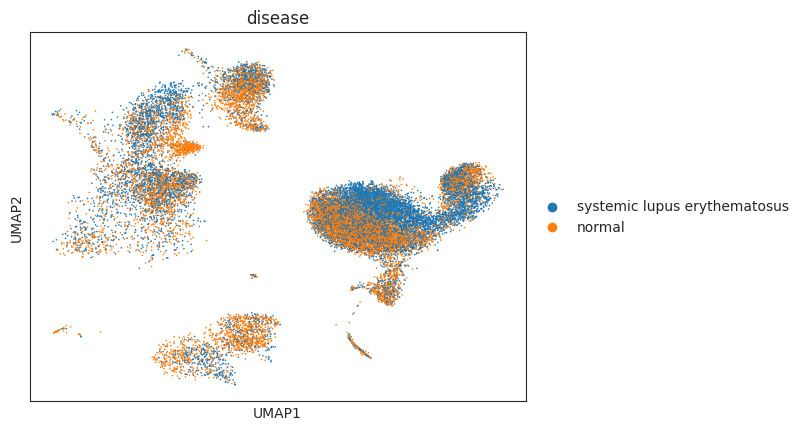

In [17]:
sc.pl.umap(adata_filtered, color='disease')

Skipping manual annotation...

Using pre-annotated cell types for research

In [18]:
if all(col in adata_filtered.obs.columns for col in ['donor_id', 'disease', 'cell_type']):
    cell_counts_final = adata_filtered.obs.groupby(
        ['donor_id', 'disease', 'cell_type']
    ).size().unstack(fill_value=0)

    # Сохраняем результаты
    cell_counts_final.to_csv('cell_counts_author_annotated.csv')

    adata_filtered.write('adata_annotated.h5ad', compression='gzip')

In [19]:
cell_counts = adata_filtered.obs.groupby(
    ['donor_id', 'disease', 'cell_type']
).size().unstack(fill_value=0)

cell_counts = cell_counts.reset_index()

In [20]:
required_columns = ['donor_id', 'disease', 'cell_type']
missing_columns = [col for col in required_columns if col not in adata_filtered.obs.columns]

if missing_columns:
    print(f"ОШИБКА: Отсутствуют колонки: {missing_columns}")
    print("Доступные колонки в adata_subsample.obs:")
    print(list(adata_filtered.obs.columns))
else:
    cell_counts = adata_filtered.obs.groupby(['donor_id', 'disease', 'cell_type']).size().unstack(fill_value=0)

    cell_counts = cell_counts.reset_index()
    print(cell_counts['disease'].value_counts())

    cell_counts['total_cells'] = cell_counts.iloc[:, 2:].sum(axis=1)
    print(f"\nМинимальное количество клеток на донора: {cell_counts['total_cells'].min()}")
    print(f"Максимальное количество клеток на донора: {cell_counts['total_cells'].max()}")


disease
systemic lupus erythematosus    12
normal                          12
Name: count, dtype: int64

Минимальное количество клеток на донора: 0
Максимальное количество клеток на донора: 4173


In [21]:
if (cell_counts['total_cells'] == 0).sum() > 0:
    zero_donors = cell_counts[cell_counts['total_cells'] == 0]['donor_id'].tolist()

In [22]:
original_size = len(cell_counts)

cell_counts_filtered = cell_counts[cell_counts['total_cells'] > 0].copy()

service_cols = ['donor_id', 'total_cells']
disease_candidates = 'disease'
if disease_candidates:
    service_cols.append(disease_candidates)

cell_type_cols = [col for col in cell_counts_filtered.columns if col not in service_cols]


In [23]:
if disease_candidates:
    disease_col = disease_candidates
    disease_dist = cell_counts_filtered[disease_col].value_counts()
    for condition, count in disease_dist.items():
        percentage = (count / len(cell_counts_filtered)) * 100
        print(f"  {condition}: {count} доноров ({percentage:.1f}%)")

  systemic lupus erythematosus: 6 доноров (50.0%)
  normal: 6 доноров (50.0%)


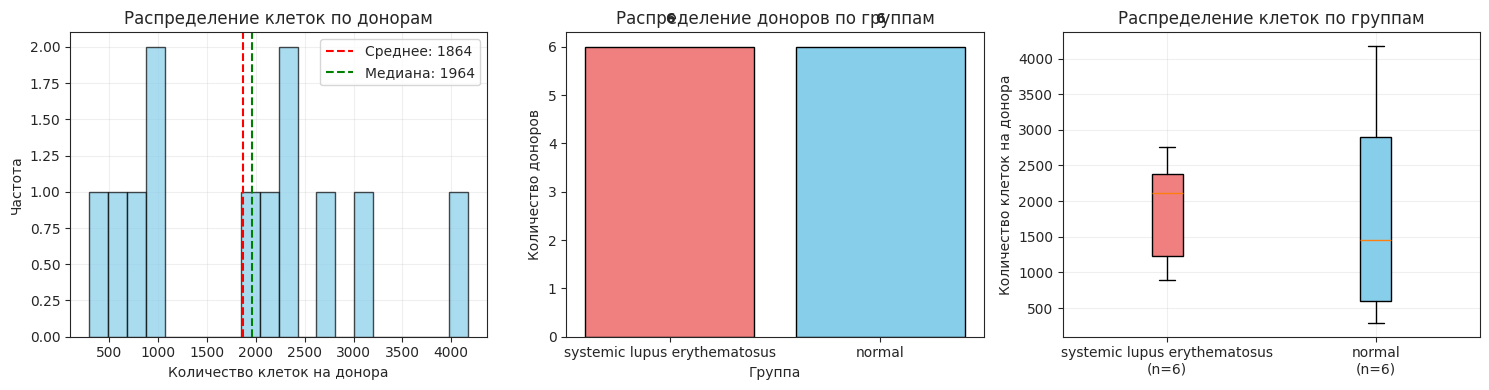

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(cell_counts_filtered['total_cells'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(cell_counts_filtered['total_cells'].mean(), color='red', linestyle='--', label=f'Среднее: {cell_counts_filtered["total_cells"].mean():.0f}')
axes[0].axvline(cell_counts_filtered['total_cells'].median(), color='green', linestyle='--', label=f'Медиана: {cell_counts_filtered["total_cells"].median():.0f}')
axes[0].set_xlabel('Количество клеток на донора')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение клеток по донорам')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

if disease_candidates:
    disease_col = disease_candidates
    disease_counts = cell_counts_filtered[disease_col].value_counts()
    colors = ['lightcoral', 'skyblue', 'lightgreen', 'gold'][:len(disease_counts)]
    axes[1].bar(disease_counts.index, disease_counts.values, color=colors, edgecolor='black')
    axes[1].set_xlabel('Группа')
    axes[1].set_ylabel('Количество доноров')
    axes[1].set_title('Распределение доноров по группам')
    for i, (idx, val) in enumerate(disease_counts.items()):
        axes[1].text(i, val + 0.5, str(val), ha='center', fontweight='bold')

if disease_candidates:
    import pandas as pd
    disease_col = disease_candidates
    boxplot_data = []
    labels = []
    for condition in cell_counts_filtered[disease_col].unique():
        condition_data = cell_counts_filtered[cell_counts_filtered[disease_col] == condition]['total_cells']
        boxplot_data.append(condition_data)
        labels.append(f"{condition}\n(n={len(condition_data)})")

    bp = axes[2].boxplot(boxplot_data, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightcoral', 'skyblue', 'lightgreen', 'gold'][:len(boxplot_data)]):
        patch.set_facecolor(color)
    axes[2].set_ylabel('Количество клеток на донора')
    axes[2].set_title('Распределение клеток по группам')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('donor_filtering_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
cell_counts_filtered.to_csv('cell_counts_for_analysis.csv', index=False)

donor_metadata = cell_counts_filtered[['donor_id', 'disease']].copy()
donor_metadata.to_csv('donor_metadata.csv', index=False)

cell_type_descriptions = pd.DataFrame({
    'cell_type': cell_counts_filtered.columns[2:-1] if 'total_cells' in cell_counts_filtered.columns else cell_counts_filtered.columns[2:]
})
cell_type_descriptions.to_csv('cell_type_descriptions.csv', index=False)

In [27]:
proportions = cell_counts_filtered.copy()
cell_type_columns = [col for col in proportions.columns
                     if col not in ['donor_id', 'disease', 'total_cells']]

for col in cell_type_columns:
    proportions[col] = proportions[col] / proportions['total_cells']

proportions.to_csv('cell_proportions_for_ttest.csv', index=False)

group_control = proportions[proportions['disease'] == 'normal']
group_white = proportions[proportions['disease'] == 'systemic lupus erythematosus']

In [28]:
proportions

cell_type,donor_id,disease,B cell,lymphocyte,natural killer cell,"CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell",plasmacytoid dendritic cell,classical monocyte,non-classical monocyte,plasmablast,conventional dendritic cell,progenitor cell,total_cells
0,1203,systemic lupus erythematosus,0.033970,0.014862,0.031847,0.264968,0.171975,0.005520,0.426327,0.030149,0.001699,0.017410,0.001274,2355
2,1225,systemic lupus erythematosus,0.000724,0.004703,0.017004,0.007959,0.005065,0.008321,0.914255,0.031838,0.000000,0.009407,0.000724,2764
4,1368,systemic lupus erythematosus,0.034517,0.005917,0.124260,0.039448,0.045365,0.006903,0.488166,0.184418,0.000000,0.070020,0.000986,1014
6,1726,systemic lupus erythematosus,0.043016,0.007435,0.073818,0.126394,0.248540,0.001593,0.323420,0.150292,0.000000,0.024960,0.000531,1883
8,1815,systemic lupus erythematosus,0.098786,0.010046,0.125994,0.076601,0.054835,0.002930,0.463374,0.148598,0.000419,0.017581,0.000837,2389
10,1947,systemic lupus erythematosus,0.031250,0.008929,0.013393,0.020089,0.059152,0.025670,0.536830,0.224330,0.001116,0.078125,0.001116,896
13,HC-006,normal,0.014174,0.011730,0.037634,0.116813,0.120235,0.000489,0.517107,0.135386,0.003421,0.041544,0.001466,2046
15,HC-554,normal,0.011723,0.011723,0.041032,0.024619,0.025791,0.011723,0.697538,0.109027,0.003517,0.058617,0.004689,853
17,ICC_control,normal,0.027397,0.013699,0.113014,0.000000,0.010274,0.017123,0.650685,0.095890,0.000000,0.071918,0.000000,292
19,IGTB826,normal,0.154956,0.011920,0.101945,0.065872,0.100690,0.021957,0.418444,0.073714,0.001255,0.047679,0.001568,3188


In [29]:
print("Доступные колонки в cell_counts:")
print(cell_counts_filtered.columns.tolist())

disease = 'disease'

service_cols = ['donor_id', 'total_cells']
if disease:
    service_cols.append(disease)

cell_type_cols = [col for col in cell_counts_filtered.columns if col not in service_cols]

sccoda_df = cell_counts_filtered[cell_type_cols + [disease]].copy()


adata_sccoda = dat.from_pandas(
    sccoda_df,
    covariate_columns=["disease"]
)

adata_sccoda.write('cell_counts_sccoda.h5ad', compression='gzip')
sccoda_csv = cell_counts_filtered[['donor_id'] + cell_type_cols + [disease]].copy()
sccoda_csv.to_csv('cell_counts_sccoda_format.csv', index=False)


if 'cell_counts_sccoda_format.csv' in globals() or 'sccoda_df' in globals():
    sample_data = sccoda_df.head(3) if 'sccoda_df' in globals() else pd.read_csv('cell_counts_sccoda_format.csv').head(3)

    if len(cell_type_cols) > 5:
        show_cols = cell_type_cols[:3] + ['...'] + cell_type_cols[-2:] + ['disease']
    else:
        show_cols = cell_type_cols + ['disease']

    for idx, row in sample_data.iterrows():
        if len(cell_type_cols) > 5:
            first_types = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols[:2]])
            last_types = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols[-2:]])
            print(f"Донор {idx+1}: {first_types}, ..., {last_types}, Условие: {row['disease']}")
        else:
            types_str = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols])
            print(f"Донор {idx+1}: {types_str}, Условие: {row['disease']}")

Доступные колонки в cell_counts:
['donor_id', 'disease', 'B cell', 'lymphocyte', 'natural killer cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'plasmacytoid dendritic cell', 'classical monocyte', 'non-classical monocyte', 'plasmablast', 'conventional dendritic cell', 'progenitor cell', 'total_cells']
Донор 1: B cell: 80, lymphocyte: 35, ..., conventional dendritic cell: 41, progenitor cell: 3, Условие: systemic lupus erythematosus
Донор 3: B cell: 2, lymphocyte: 13, ..., conventional dendritic cell: 26, progenitor cell: 2, Условие: systemic lupus erythematosus
Донор 5: B cell: 35, lymphocyte: 6, ..., conventional dendritic cell: 71, progenitor cell: 1, Условие: systemic lupus erythematosus


In [30]:
sccoda_csv

cell_type,donor_id,B cell,lymphocyte,natural killer cell,"CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell",plasmacytoid dendritic cell,classical monocyte,non-classical monocyte,plasmablast,conventional dendritic cell,progenitor cell,disease
0,1203,80,35,75,624,405,13,1004,71,4,41,3,systemic lupus erythematosus
2,1225,2,13,47,22,14,23,2527,88,0,26,2,systemic lupus erythematosus
4,1368,35,6,126,40,46,7,495,187,0,71,1,systemic lupus erythematosus
6,1726,81,14,139,238,468,3,609,283,0,47,1,systemic lupus erythematosus
8,1815,236,24,301,183,131,7,1107,355,1,42,2,systemic lupus erythematosus
10,1947,28,8,12,18,53,23,481,201,1,70,1,systemic lupus erythematosus
13,HC-006,29,24,77,239,246,1,1058,277,7,85,3,normal
15,HC-554,10,10,35,21,22,10,595,93,3,50,4,normal
17,ICC_control,8,4,33,0,3,5,190,28,0,21,0,normal
19,IGTB826,494,38,325,210,321,70,1334,235,4,152,5,normal


t-test analysis:

In [32]:
proportions = pd.read_csv('cell_counts_for_analysis.csv', index_col=0)
metadata = pd.read_csv('donor_metadata.csv')

analysis_df = proportions.merge(
    metadata,
    left_index=True,
    right_on='donor_id',
    suffixes=('_prop', '_meta')
)

cell_type_columns = [col for col in proportions.columns
                     if col not in ['disease', 'total_cells']]

group_col = 'disease_prop'
groups = analysis_df[group_col].unique()
if len(groups) == 2:
    group1, group2 = groups[0], groups[1]
    print(f"Сравниваем группы: '{group1}' vs '{group2}'")

    results = []
    for cell_type in cell_type_columns:
        data_group1 = analysis_df[analysis_df[group_col] == group1][cell_type]
        data_group2 = analysis_df[analysis_df[group_col] == group2][cell_type]

        if len(data_group1) >= 3 and len(data_group2) >= 3:
            t_stat, p_val = ttest_ind(data_group1, data_group2, equal_var=False, nan_policy='omit')
            mean_diff = data_group1.mean() - data_group2.mean()
            results.append({
                'cell_type': cell_type,
                'mean_diff': mean_diff,
                't_statistic': t_stat,
                'p_value': p_val
            })

    ttest_results = pd.DataFrame(results)

    if len(ttest_results) > 0:
        ttest_results['p_value_adj'] = multipletests(ttest_results['p_value'], method='fdr_bh')[1]
        ttest_results['significant'] = ttest_results['p_value_adj'] < 0.1

        ttest_results.sort_values('p_value').to_csv('ttest_results.csv', index=False)
        print(f"Значимых типов клеток (FDR < 0.05): {ttest_results['significant'].sum()} из {len(ttest_results)}")

        print("Топ-5 значимых типов клеток по t-test:")
        print(ttest_results[ttest_results['significant']].sort_values('p_value').head(5)[['cell_type', 'mean_diff', 'p_value_adj']])
else:
    print(f"Найдено {len(groups)} групп. Ожидается 2 группы для t-test.")

Сравниваем группы: 'systemic lupus erythematosus' vs 'normal'
Значимых типов клеток (FDR < 0.05): 0 из 11
Топ-5 значимых типов клеток по t-test:
Empty DataFrame
Columns: [cell_type, mean_diff, p_value_adj]
Index: []


In [33]:
ttest_results

,cell_type,mean_diff,t_statistic,p_value,p_value_adj,significant
0,B cell,-93.333333,-0.888847,0.407398,0.833056,False
1,lymphocyte,-0.833333,-0.117897,0.908576,0.961326,False
2,natural killer cell,-82.000000,-0.688851,0.515210,0.833056,False
3,"CD4-positive, alpha-beta T cell",-7.166667,-0.049740,0.961326,0.961326,False
4,"CD8-positive, alpha-beta T cell",-20.666667,-0.158015,0.877755,0.961326,False
5,plasmacytoid dendritic cell,-16.333333,-1.262233,0.255297,0.833056,False
6,classical monocyte,247.000000,0.654236,0.530127,0.833056,False
7,non-classical monocyte,51.166667,0.854112,0.413311,0.833056,False
8,plasmablast,-3.333333,-1.869894,0.107559,0.684417,False
9,conventional dendritic cell,-35.666667,-1.766028,0.124439,0.684417,False


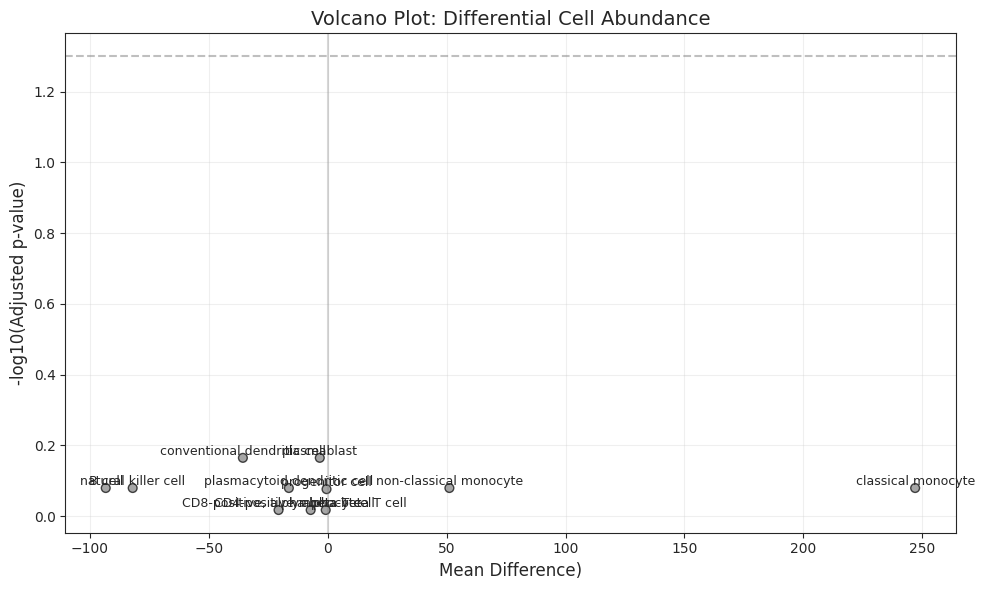

In [34]:
plt.figure(figsize=(10, 6))

colors = ['red' if sig else 'gray' for sig in ttest_results['significant']]
sizes = [80 if sig else 40 for sig in ttest_results['significant']]

plt.scatter(ttest_results['mean_diff'],
            -np.log10(ttest_results['p_value_adj']),
            c=colors, s=sizes, alpha=0.7, edgecolors='black')

for i, row in ttest_results.iterrows():
    plt.text(row['mean_diff'],
             -np.log10(row['p_value_adj']),
             row['cell_type'],
             fontsize=9, ha='center', va='bottom')

plt.axhline(-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='-', alpha=0.3)

plt.xlabel('Mean Difference)', fontsize=12)
plt.ylabel('-log10(Adjusted p-value)', fontsize=12)
plt.title('Volcano Plot: Differential Cell Abundance', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('volcano_plot.png', dpi=300)
plt.show()

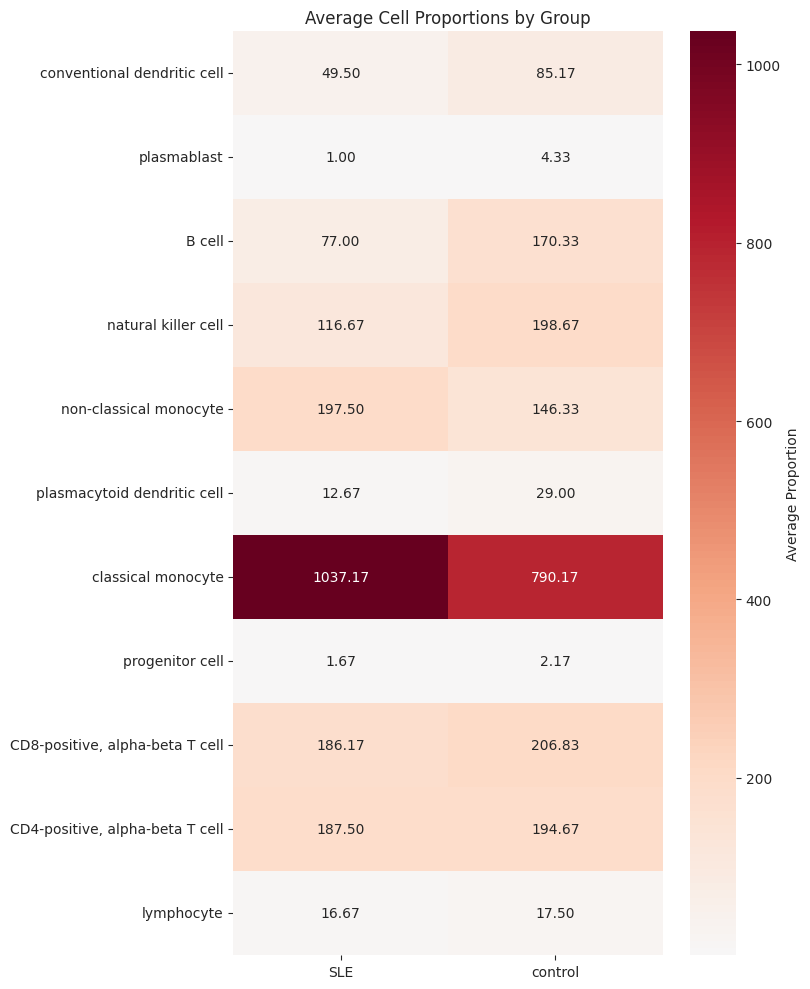

In [35]:
top_cells = ttest_results.sort_values('p_value_adj').head(15)['cell_type'].tolist()

group_means = pd.DataFrame({
    'SLE': analysis_df[analysis_df[group_col] == group1][top_cells].mean(),
    'control': analysis_df[analysis_df[group_col] == group2][top_cells].mean()
})

plt.figure(figsize=(8, 10))
sns.heatmap(group_means,
            cmap='RdBu_r',
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Average Proportion'})
plt.title('Average Cell Proportions by Group')
plt.tight_layout()
plt.savefig('heatmap_group_means.png', dpi=300)
plt.show()

scCODA analysis:

In [36]:
counts_df = pd.read_csv('cell_counts_sccoda_format.csv', index_col=0)
metadata_df = pd.read_csv('donor_metadata.csv').set_index('donor_id')

if 'disease' in metadata_df.columns:
    metadata_df = metadata_df.rename(columns={'disease': 'group'})

cols_to_drop = ['disease', 'total_cells', 'cell_type']
existing_cols = [col for col in cols_to_drop if col in counts_df.columns]
if existing_cols:
    counts_df = counts_df.drop(columns=existing_cols)

sccoda_df = counts_df.join(metadata_df, how='inner')

adata_sccoda = dat.from_pandas(
    sccoda_df,
    covariate_columns=["group"]
)

In [37]:
sccoda_df

,B cell,lymphocyte,natural killer cell,"CD4-positive, alpha-beta T cell","CD8-positive, alpha-beta T cell",plasmacytoid dendritic cell,classical monocyte,non-classical monocyte,plasmablast,conventional dendritic cell,progenitor cell,group
donor_id,,,,,,,,,,,,
1203,80,35,75,624,405,13,1004,71,4,41,3,systemic lupus erythematosus
1225,2,13,47,22,14,23,2527,88,0,26,2,systemic lupus erythematosus
1368,35,6,126,40,46,7,495,187,0,71,1,systemic lupus erythematosus
1726,81,14,139,238,468,3,609,283,0,47,1,systemic lupus erythematosus
1815,236,24,301,183,131,7,1107,355,1,42,2,systemic lupus erythematosus
1947,28,8,12,18,53,23,481,201,1,70,1,systemic lupus erythematosus
HC-006,29,24,77,239,246,1,1058,277,7,85,3,normal
HC-554,10,10,35,21,22,10,595,93,3,50,4,normal
ICC_control,8,4,33,0,3,5,190,28,0,21,0,normal


In [38]:
model = mod.CompositionalAnalysis(
    data=adata_sccoda,
    formula="group",
    reference_cell_type="automatic"
)

results = model.sample_hmc()

results.save("sccoda_results")

Automatic reference selection! Reference cell type set to lymphocyte
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [04:11<00:00, 79.53it/s]


MCMC sampling finished. (317.603 sec)
Acceptance rate: 56.5%


In [39]:
print("Краткие результаты scCODA:")
summary = results.summary()
print(summary)

credible_effects = results.credible_effects()
print(f"Значимо измененные типы клеток (вероятность > 0.95): {credible_effects.sum()}")

Краткие результаты scCODA:
Compositional Analysis summary:

Data: 12 samples, 11 cell types
Reference index: 1
Formula: group

Intercepts:
                                 Final Parameter  Expected Sample
Cell Type                                                        
B cell                                     0.034        83.257841
lymphocyte                                -0.564        45.784349
natural killer cell                        0.548       139.204254
CD4-positive, alpha-beta T cell            0.313       110.050825
CD8-positive, alpha-beta T cell            0.470       128.758983
plasmacytoid dendritic cell               -0.622        43.204398
classical monocyte                         2.474       955.220596
non-classical monocyte                     0.945       207.046272
plasmablast                               -1.335        21.177564
conventional dendritic cell                0.310       109.721167
progenitor cell                           -1.334        21.198752


E

<Axes: xlabel='Cell type', ylabel='Proportion'>

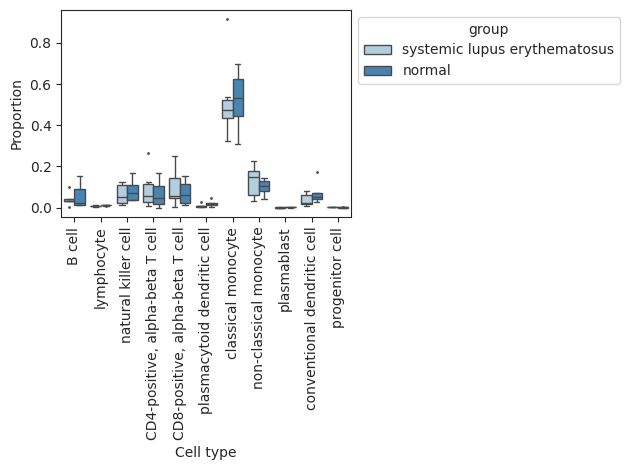

In [40]:
viz.boxplots(adata_sccoda, feature_name="group")

Так тоже значимых различий нет :(